In [4]:
!git clone https://github.com/Soumedhik/Essay-Grading-System.git

fatal: destination path 'Essay-Grading-System' already exists and is not an empty directory.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


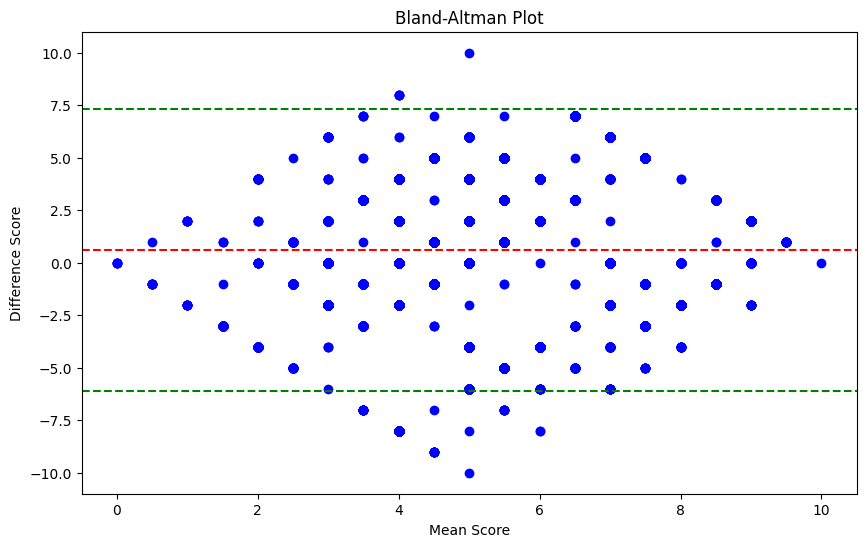

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
import re
import tensorflow as tf
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l2
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import BatchNormalization, LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, cohen_kappa_score, confusion_matrix
from scipy.stats import linregress

w2v_path = '/content/Essay-Grading-System/word2vecmodel.bin'
word2vec_model = KeyedVectors.load(w2v_path, mmap='r')

def get_model2():
    model = Sequential()
    model.add(BatchNormalization(input_shape=[1, 600]))
    model.add(Bidirectional(LSTM(512, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(11, activation='softmax'))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

lstm_model2 = get_model2()
lstm_model2.load_weights("/content/essay_rank_lstm_2.keras")

def essay_to_vector(essay, model):
    essay = essay.lower()
    words = essay.split()
    essay_vec = np.zeros((model.vector_size,), dtype="float32")
    no_of_words = 0
    for word in words:
        if word in model:
            no_of_words += 1
            essay_vec = np.add(essay_vec, model[word])
    if no_of_words != 0:
        essay_vec = np.divide(essay_vec, no_of_words)
    return np.reshape(essay_vec, (1, 1, -1))

def predict_score(essay):
    vector = essay_to_vector(essay, word2vec_model)
    prediction = lstm_model2.predict(vector)
    score = np.argmax(prediction)
    return score

def evaluate_metrics(X, y):
    y_pred = [predict_score(essay) for essay in X]
    mae = mean_absolute_error(y, y_pred)
    qwk = cohen_kappa_score(y, y_pred, weights='quadratic')
    cm = confusion_matrix(y, y_pred)
    mean_scores = np.mean([y, y_pred], axis=0)
    diff_scores = np.array(y) - np.array(y_pred)
    mean_diff = np.mean(diff_scores)
    std_diff = np.std(diff_scores)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 6))
    plt.scatter(mean_scores, diff_scores, color='blue')
    plt.axhline(mean_diff, color='red', linestyle='--')
    plt.axhline(upper_limit, color='green', linestyle='--')
    plt.axhline(lower_limit, color='green', linestyle='--')
    plt.title('Bland-Altman Plot')
    plt.xlabel('Mean Score')
    plt.ylabel('Difference Score')
    plt.show()

    return mae, qwk, cm

df = pd.read_csv("/content/Essay-Grading-System/Processed_data.csv")
df.dropna(axis=1,inplace=True)
y = df['final_score']
df.drop('final_score',inplace=True,axis=1)
X=df['essay']

mae, qwk, cm = evaluate_metrics(X.tolist(), y.tolist())

In [21]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Quadratic Weighted Kappa (QWK): {qwk}")

Mean Absolute Error (MAE): 1.1660856966707769
Quadratic Weighted Kappa (QWK): 0.6744956036729489
